In [2]:
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn. metrics import roc_auc_score, accuracy_score
import seaborn as sns
import numpy as np

In [3]:
df = pd.read_csv('../data/train_1M_with_features_merged_v3.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987269 entries, 0 to 987268
Data columns (total 61 columns):
 #   Column                                                           Non-Null Count   Dtype  
---  ------                                                           --------------   -----  
 0   Unnamed: 0                                                       987269 non-null  int64  
 1   row_id                                                           987269 non-null  int64  
 2   timestamp                                                        987269 non-null  int64  
 3   user_id                                                          987269 non-null  int64  
 4   content_id                                                       987269 non-null  int64  
 5   content_type_id                                                  987269 non-null  int64  
 6   task_container_id                                                987269 non-null  int64  
 7   answered_correctly           

In [7]:
to_drop=['answered_correctly',
         'Unnamed: 0',
         'row_id',
         'timestamp',
         'user_id',
         'content_id',
         'content_type_id',
         'prior_question_elapsed_time',
         'answer0',
         'answer1',
         'answer2',
         'answer3',
         ]

In [8]:
train=df.query('content_type_id==0').drop(columns=to_drop).replace(np.inf,0)
X_tot=train
y=df.query('content_type_id==0')['answered_correctly']

In [9]:
from sklearn.preprocessing import RobustScaler
corr = df.query('content_type_id==0').corr().answered_correctly
corr.sort_values(ascending=False)

answered_correctly                                              1.000000
user_personalized_qstat_knowing_had_explanation_or_not          0.393328
qstats_answered_correctly                                       0.380770
qstats_answered_correctly_knowing_having_had_explanation        0.373850
qstats_answered_correctly_knowing_having_not_had_explanation    0.211393
                                                                  ...   
part5                                                          -0.080024
qstats_count                                                   -0.140667
content_type_id                                                      NaN
qstats_timestamp                                                     NaN
qstats_timestamp_knowing_answered_correctly                          NaN
Name: answered_correctly, Length: 61, dtype: float64

# Essai xgboost 14 features

In [10]:
#corr[corr > 0.04].sort_values(ascending=False).index.to_list()
features = ['user_personalized_qstat_knowing_had_explanation_or_not',
            'user_avg_score_cum_on_this_part',
            'user_correct_answers_cum_on_this_part',
 'qstats_answered_correctly',
 'user_avg_score_cum',
 'qstats_prior_question_had_explanation',
 'already_seen',
 #'already_seen_tag_lecture',
 'user_activity_cumcount',
 #'qstats_user_activity_cumcount',
 'at_least_one_lesson',
 #'qstats_user_activity_cumcount_knowing_answered_correctly',
 #'qstats_task_container_id_knowing_answered_correctly',
 #'lectures_seen',
 #'qstats_count',
 #'qstats_answers',
 'content_type_id',
  'same_user_and_similar_to_prior',
            'similar_to_prior_and_had_answered_correctly',
            'similar_to_prior_and_have_had_explanation']

In [14]:
feats=df.loc[df.content_type_id==0,features]
print(feats.info())
feats = feats.replace(np.inf, 0.5)
feats.replace(np.nan, 0, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 967834 entries, 0 to 987268
Data columns (total 13 columns):
 #   Column                                                  Non-Null Count   Dtype  
---  ------                                                  --------------   -----  
 0   user_personalized_qstat_knowing_had_explanation_or_not  967834 non-null  float64
 1   user_avg_score_cum_on_this_part                         967834 non-null  float64
 2   user_correct_answers_cum_on_this_part                   967834 non-null  float64
 3   qstats_answered_correctly                               967834 non-null  float64
 4   user_avg_score_cum                                      967834 non-null  float64
 5   qstats_prior_question_had_explanation                   967834 non-null  float64
 6   already_seen                                            967834 non-null  int64  
 7   user_activity_cumcount                                  967834 non-null  int64  
 8   at_least_one_lesson     

In [13]:
feats.query('content_type_id==0')

,user_personalized_qstat_knowing_had_explanation_or_not,user_avg_score_cum_on_this_part,user_correct_answers_cum_on_this_part,qstats_answered_correctly,user_avg_score_cum,qstats_prior_question_had_explanation,already_seen,user_activity_cumcount,at_least_one_lesson,content_type_id,same_user_and_similar_to_prior,similar_to_prior_and_had_answered_correctly,similar_to_prior_and_have_had_explanation
0,0.8364,0.0,0.0,0.8370,0.000000,0.07404,0,0,0,0,0.0,-0.0,0.0
1,0.3770,1.0,1.0,0.3972,1.000000,0.11970,0,1,0,0,0.5,0.5,0.0
2,0.3513,0.5,1.0,0.3640,0.500000,0.14160,0,2,0,0,0.5,0.0,0.0
3,0.6450,0.0,0.0,0.6514,0.333333,0.05120,0,3,0,0,0.0,0.0,0.0
4,0.1642,0.0,0.0,0.1749,0.250000,0.09250,0,4,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
987264,0.5930,1.0,3.0,0.5967,0.600000,0.23200,0,25,0,0,0.5,0.5,0.0
987265,0.4854,0.0,0.0,0.5063,0.615385,0.07830,0,26,0,0,0.0,0.0,0.0
987266,0.4270,1.0,1.0,0.4424,0.629630,0.07830,0,27,0,0,0.5,0.5,0.0
987267,0.2842,1.0,2.0,0.2932,0.642857,0.07830,0,28,0,0,0.5,0.5,0.0


Best so far - XGBoost


In [12]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

X = feats.query('content_type_id==0').drop(columns={'content_type_id'})
y = df.query('content_type_id==0')['answered_correctly']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 2)

scaler = MinMaxScaler()
xgboost = HistGradientBoostingClassifier()
xgboost_pipe = make_pipeline(scaler,xgboost)


y_pred = cross_val_predict(xgboost_pipe, X, y, cv=5, method='predict_proba', verbose=1)
print('roc-auc:', roc_auc_score(y, y_pred[:,1]))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished


roc-auc: 0.7698138199898431


In [43]:
xgboost_pipe

TypeError: 'Pipeline' object is not subscriptable

In [ ]:
features.columns

Index(['user_personalized_qstat_knowing_had_explanation_or_not',
       'qstats_answered_correctly', 'user_avg_score_cum',
       'qstats_prior_question_had_explanation', 'already_seen',
       'already_seen_tag_lecture', 'user_activity_cumcount',
       'qstats_user_activity_cumcount', 'at_least_one_lesson',
       'qstats_user_activity_cumcount_knowing_answered_correctly',
       'qstats_task_container_id_knowing_answered_correctly', 'lectures_seen',
       'qstats_count', 'qstats_answers', 'content_type_id'],
      dtype='object')

# En enlevant la cross val

In [15]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

X = feats.query('content_type_id==0').drop(columns={'content_type_id'})
y = df.query('content_type_id==0')['answered_correctly']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 1)

scaler = MinMaxScaler()
xgboost = HistGradientBoostingClassifier()
xgboost_pipe = make_pipeline(scaler,xgboost)

xgboost_pipe.fit (X_train, y_train)

y_pred = xgboost_pipe.predict_proba(X_test)
print('roc-auc:', roc_auc_score(y_test, y_pred[:,1]))

roc-auc: 0.7722514290349689


In [17]:
y_red_bin = xgboost_pipe.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_red_bin))

accuracy: 0.7299957637480153


In [25]:
y_pred

array([[0.5128708 , 0.4871292 ],
       [0.23027739, 0.76972261],
       [0.52994319, 0.47005681],
       ...,
       [0.0511856 , 0.9488144 ],
       [0.53711004, 0.46288996],
       [0.77120537, 0.22879463]])

In [24]:
y_pred[:,1]

array([0.4871292 , 0.76972261, 0.47005681, ..., 0.9488144 , 0.46288996,
       0.22879463])

In [33]:
accuracy_score(y_test, y_pred[:,1]>0.7)

0.6722690812154943

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])

df_threshold=pd.DataFrame({'recall':recall[:-1], 'precision':precision[:-1]},index=thresholds)
df_threshold=df_threshold.sample(n=1000)

In [42]:
thresholds=df_threshold.index.to_list()

In [43]:
accuracies=[]
for thres in thresholds:
    accuracies.append(accuracy_score(y_test, y_pred[:,1]>thres))

In [45]:
df_threshold['accuracy']=accuracies

In [50]:
df_threshold=df_threshold.sort_index(axis=0)

,recall,precision,accuracy
0.061623,0.999879,0.657477,0.658217
0.061957,0.999879,0.657495,0.658238
0.069008,0.999827,0.657794,0.658682
0.142372,0.999281,0.659554,0.661169
0.146519,0.999029,0.659993,0.661751
...,...,...,...
0.999130,0.005471,1.000000,0.347586
0.999141,0.004872,1.000000,0.347200
0.999164,0.003911,1.000000,0.346553
0.999210,0.002315,1.000000,0.345527


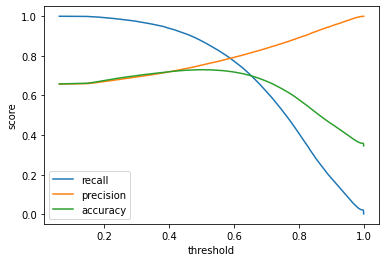

In [51]:
#Computing the minimum threshold, considering required precision
#required_precision = 0.9
#minimum_required_threshold= df_threshold[df_threshold['precision']>required_precision].index[0]

df_threshold.plot()
#plt.plot([0,1],[required_precision,required_precision])
#plt.plot([minimum_required_threshold,minimum_required_threshold],[0,1])
plt.xlabel('threshold')
plt.xlabel('threshold')
plt.ylabel('score')
df_threshold

# Re-run sur tout le train et export pickle

In [16]:
xgboost_pipe.fit (X, y)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier())])

In [17]:
import pickle
pickle.dump(xgboost_pipe, open("xgboost_pipe3.pkl", "wb") )

In [92]:
features = ['user_personalized_qstat_knowing_had_explanation_or_not',
            'user_avg_score_cum_on_this_part',
            'user_correct_answers_cum_on_this_part',
 'qstats_answered_correctly',
 'user_avg_score_cum',
 'qstats_prior_question_had_explanation',
 'already_seen',
 #'already_seen_tag_lecture',
 'user_activity_cumcount',
 #'qstats_user_activity_cumcount',
 'at_least_one_lesson',
 #'qstats_user_activity_cumcount_knowing_answered_correctly',
 #'qstats_task_container_id_knowing_answered_correctly',
 #'lectures_seen',
 #'qstats_count',
 #'qstats_answers',
 'content_type_id']

pd.Series(features[:-1]).to_csv('xgboost_pipe3_features_list.csv')

pd.Series(features[:-1])

0    user_personalized_qstat_knowing_had_explanatio...
1                      user_avg_score_cum_on_this_part
2                user_correct_answers_cum_on_this_part
3                            qstats_answered_correctly
4                                   user_avg_score_cum
5                qstats_prior_question_had_explanation
6                                         already_seen
7                               user_activity_cumcount
8                                  at_least_one_lesson
dtype: object

# Logistic Regression

In [ ]:
X = df.query('content_type_id==0')[['qstats_answered_correctly', 'user_avg_score_cum', 'already_seen', 'lectures_seen', 'at_least_one_lesson']]
y = df.query('content_type_id==0')['answered_correctly']

In [ ]:
X = features.query('content_type_id==0').drop(columns={'content_type_id'})
y = df.query('content_type_id==0')['answered_correctly']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 2)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

log = LogisticRegression()
log.fit(X_train, y_train)
y_pred = cross_val_predict(log, X_test, y_test, cv=10, method='predict_proba', verbose=1)
print('roc-auc:', roc_auc_score(y_test, y_pred[:,1]))

Correlations

In [ ]:
corr.sort_values(ascending=False)

In [ ]:
corr = df.query('content_type_id==0').corr().answered_correctly

# RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X = df.query('content_type_id==0')[['qstats_answered_correctly', 'user_avg_score_cum', 'already_seen', 'lectures_seen', 'at_least_one_lesson']]
y = df.query('content_type_id==0')['answered_correctly']

In [ ]:
y_pred = cross_val_predict(forest, X_test, y_test, cv=10, method='predict_proba', verbose=1)
print('roc-auc:', roc_auc_score(y_test, y_pred[:,1]))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


roc-auc: 0.7125921037505767


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  7.0min finished


# Bagging Classifier

# Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 1)
adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=50) 
adaboost.fit(X_train, y_train)

y_pred = cross_val_predict(adaboost, X_test, y_test, cv=10, method='predict_proba', verbose=1)
print('roc-auc:', roc_auc_score(y_test, y_pred[:,1]))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


roc-auc: 0.7594259462782705


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.3min finished


# SVC

In [ ]:
from sklearn.svm import SVC

X = features.query('content_type_id==0').drop(columns={'content_type_id'})
y = df.query('content_type_id==0')['answered_correctly']

kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']

for kernel in kernels:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 2)
  X_train = scaler.fit_transform(X_train)
  svc = SVC(kernel=kernel, C=10, max_iter=1500, probability=True, tol=0.01, gamma='scale')
  svc.fit(X_train, y_train)
  y_pred = cross_val_predict(svc, X_test, y_test, cv=5, method='predict_proba', verbose=1)
  print('roc-auc:', roc_auc_score(y_test, y_pred[:,1]))

In [ ]:
# equivalent but with SGD solver
from sklearn.linear_model import SGDClassifier

svc_bis = SGDClassifier(loss='modified_huber', penalty='l2', alpha=0.1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 1)

#svc_bis = GradientBoostingClassifier() 
svc_bis.fit(X_train, y_train)

y_pred = cross_val_predict(svc_bis, X_test, y_test, cv=10, method='predict_proba', verbose=1)
print('roc-auc:', roc_auc_score(y_test, y_pred[:,1]))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


roc-auc: 0.7289342611288083


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.3s finished


# Multi-layer Stacking - XGBoost, SVC and Log reg

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()

X = features.query('content_type_id==0').drop(columns={'content_type_id'})
y = df.query('content_type_id==0')['answered_correctly']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 2)

X_train = scaler.fit_transform(X_train)


ensemble = StackingClassifier(
    estimators = [("log", GradientBoostingClassifier()),
                  ("svc", SGDClassifier(loss='modified_huber', penalty='l2', alpha=0.1, max_iter=3000))],
                  final_estimator = LogisticRegression(max_iter=3000) )

ensemble.fit(X_train, y_train)
y_pred = cross_val_predict(ensemble, X_test, y_test, cv=5, method='predict_proba', verbose=1)
print('roc-auc:', roc_auc_score(y_test, y_pred[:,1]))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


roc-auc: 0.7682322465652832


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 25.1min finished


In [6]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [2]:
pip freeze

absl-py==0.11.0
aiobotocore==1.1.2
aiohttp==3.7.3
aioitertools==0.7.1
alembic==1.4.1
altair==4.1.0
appnope==0.1.0
argon2-cffi==20.1.0
astor==0.8.1
astroid==2.4.2
astunparse==1.6.3
async-generator==1.10
async-timeout==3.0.1
attrs==20.2.0
azure-core==1.9.0
azure-storage-blob==12.6.0
backcall==0.2.0
base58==2.0.1
beautifulsoup4==4.9.3
bleach==3.2.1
blinker==1.4
botocore==1.17.44
branca==0.4.1
bs4==0.0.1
cachetools==4.1.1
category-encoders==2.2.2
certifi==2020.6.20
cffi==1.14.3
chardet==3.0.4
chromedriver-binary==86.0.4240.22.0
click==7.1.2
cloudpickle==1.6.0
confuse==1.3.0
coverage==5.3
cryptography==3.2.1
cycler==0.10.0
Cython==0.29.17
databricks-cli==0.14.1
deap==1.3.1
decorator==4.4.2
defusedxml==0.6.0
docker==4.4.0
docutils==0.15.2
entrypoints==0.3
Flask==1.1.1
Flask-Cors==3.0.9
folium==0.11.0
fsspec==0.8.4
future==0.18.2
gast==0.3.3
gcsfs==0.6.0
gensim==3.8.3
gitdb==4.0.5
GitPython==3.1.11
google-api-core==1.23.0
google-auth==1.23.0
google-auth-oauthlib==0.4.2
google-cloud-core==1.4.

# Neural network

In [29]:
to_drop=['answered_correctly',
         'Unnamed: 0',
         'row_id',
         'timestamp',
         'user_id',
         'content_id',
         'content_type_id',
         'prior_question_elapsed_time',
         'answer0',
         'answer1',
         'answer2',
         'answer3',
         ]
X_tot=df.query('content_type_id==0').drop(columns=to_drop)
X_tot.replace(np.inf,0,inplace=True)

In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

X_train, X_test, y_train, y_test = train_test_split(X_tot, y, test_size=0.3, random_state = 2)

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
imput=SimpleImputer(strategy='most_frequent')
X_imputed=imput.fit_transform(X_train)

scaler=RobustScaler()
X_scaled=scaler.fit_transform(X_imputed)

model = Sequential()

# Première couche connectée aux inputs:
model.add(layers.Dense(10, input_dim=49 ,activation='relu')) # The model has to know the size of your 
#input as it directly impose the number of weights in the linear combinations of the neurons of the first layer

model.add(layers.Dense(20, activation='relu')) # First layer : 10 neurons and ReLU as activation function
model.add(layers.Dense(20, activation='linear'))
#model.add(layers.Dense(30, activation='sigmoid'))
#model.add(layers.Dense(10, activation='softmax'))
model.add(layers.Dense(10, activation='relu'))
#Output
model.add(layers.Dense(1, activation='sigmoid'))# Exemple avec une classif

model.compile(loss='binary_crossentropy', optimizer='adam')

from tensorflow.keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=2, mode='auto',
    restore_best_weights=True)

history = model.fit(X_scaled, y_train, 
                    epochs=500, 
                    batch_size=16, 
                    verbose=2,
                    validation_split=0.3, # utiliser un sous-set de validation
                    callbacks=[es])

Epoch 1/500
29640/29640 - 44s - loss: 0.5703 - val_loss: 0.5328
Epoch 2/500
29640/29640 - 44s - loss: 0.5326 - val_loss: 0.5307
Epoch 3/500
29640/29640 - 43s - loss: 0.5330 - val_loss: 0.5286
Epoch 4/500
29640/29640 - 43s - loss: 0.5315 - val_loss: 0.5295
Epoch 5/500
29640/29640 - 44s - loss: 0.5309 - val_loss: 0.5265
Epoch 6/500
29640/29640 - 43s - loss: 0.5323 - val_loss: 0.5276
Epoch 7/500
29640/29640 - 43s - loss: 0.5292 - val_loss: 0.5296
Epoch 8/500
29640/29640 - 44s - loss: 0.5336 - val_loss: 0.5278
Epoch 9/500
29640/29640 - 44s - loss: 0.5275 - val_loss: 0.5263
Epoch 10/500
29640/29640 - 43s - loss: 0.5270 - val_loss: 0.5270
Epoch 11/500
29640/29640 - 43s - loss: 0.5269 - val_loss: 0.5270
Epoch 12/500
29640/29640 - 43s - loss: 0.5268 - val_loss: 0.5258
Epoch 13/500
29640/29640 - 43s - loss: 0.5266 - val_loss: 0.5270
Epoch 14/500
29640/29640 - 42s - loss: 0.5265 - val_loss: 0.5267
Epoch 15/500
29640/29640 - 43s - loss: 0.5265 - val_loss: 0.5255
Epoch 16/500
29640/29640 - 43s - l

KeyboardInterrupt: 

In [27]:
X_test_imputed=imput.transform(X_test)
X_test_scaled=scaler.transform(X_test_imputed)
y_pred=model.predict_proba(X_test_scaled)

Instructions for updating:
Please use `model.predict()` instead.


In [30]:
y_pred

array([[0.73454094],
       [0.80930424],
       [0.89958954],
       ...,
       [0.66425   ],
       [0.3704781 ],
       [0.5426458 ]], dtype=float32)

In [31]:
print('roc-auc:', roc_auc_score(y_test, y_pred[:,0]))

roc-auc: 0.7768662652910923


In [26]:
model2 = Sequential()

# Première couche connectée aux inputs:
model2.add(layers.Dense(10, input_dim=46 ,activation='relu')) # The model has to know the size of your 
#input as it directly impose the number of weights in the linear combinations of the neurons of the first layer
model2.add(layers.Dropout(rate=0.2))
model2.add(layers.Dense(20, activation='relu')) # First layer : 10 neurons and ReLU as activation function
model2.add(layers.Dropout(rate=0.2))
model2.add(layers.Dense(20, activation='linear'))
model2.add(layers.Dropout(rate=0.2))
model2.add(layers.Dense(20, activation='softmax'))
#model.add(layers.Dense(10, activation='softmax'))
model2.add(layers.Dense(10, activation='relu'))
#Output
model2.add(layers.Dense(1, activation='sigmoid'))# Exemple avec une classif

model2.compile(loss='binary_crossentropy', optimizer='adam')

from tensorflow.keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=2, mode='auto',
    restore_best_weights=True)

history2 = model2.fit(X_scaled, y_train, 
                    epochs=1000, 
                    batch_size=16, 
                    verbose=2,
                    validation_split=0.3, # utiliser un sous-set de validation
                    callbacks=[es])

Epoch 1/1000
29640/29640 - 51s - loss: 0.5486 - val_loss: 0.5359
Epoch 2/1000
29640/29640 - 50s - loss: 0.5401 - val_loss: 0.5364
Epoch 3/1000
29640/29640 - 50s - loss: 0.5388 - val_loss: 0.5324
Epoch 4/1000
29640/29640 - 50s - loss: 0.5385 - val_loss: 0.5331
Epoch 5/1000
29640/29640 - 50s - loss: 0.5378 - val_loss: 0.5350
Epoch 6/1000
29640/29640 - 50s - loss: 0.5377 - val_loss: 0.5337
Epoch 7/1000
29640/29640 - 50s - loss: 0.5372 - val_loss: 0.5326
Epoch 8/1000
29640/29640 - 50s - loss: 0.5373 - val_loss: 0.5329
Epoch 9/1000
29640/29640 - 50s - loss: 0.5369 - val_loss: 0.5311
Epoch 10/1000
29640/29640 - 50s - loss: 0.5369 - val_loss: 0.5319
Epoch 11/1000
29640/29640 - 50s - loss: 0.5368 - val_loss: 0.5324
Epoch 12/1000
29640/29640 - 50s - loss: 0.5365 - val_loss: 0.5326
Epoch 13/1000
29640/29640 - 50s - loss: 0.5364 - val_loss: 0.5323
Epoch 14/1000
29640/29640 - 51s - loss: 0.5365 - val_loss: 0.5339
Epoch 15/1000
29640/29640 - 50s - loss: 0.5364 - val_loss: 0.5338
Epoch 16/1000
29640